Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


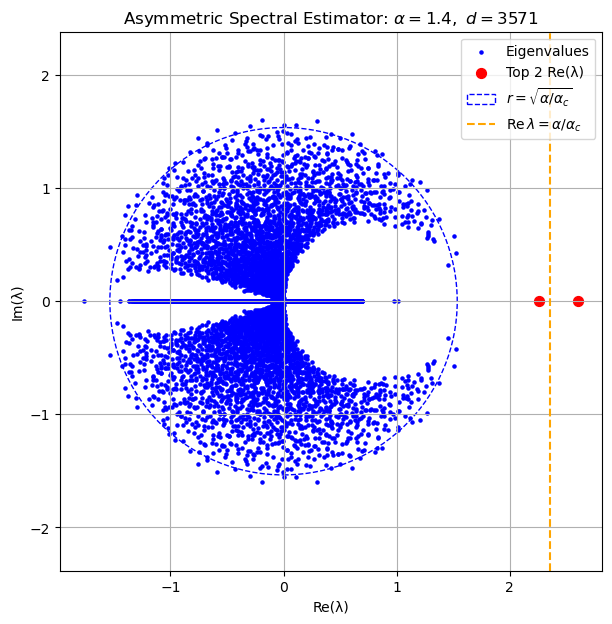

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# Fix random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Configuration parameters
n = 5000   # Number of samples
p = 2      # Signal subspace dimension
alpha = 1.4
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Generate input matrix X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: Construct true signal subspace W* and observations Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # Link function: y = z1 * z2

# Step 3: Compute preprocessing function G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # Numerical stability

# Construct G(y): each sample corresponds to a 2×2 symmetric matrix
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: Build the asymmetric spectral matrix L ∈ ℝ^{np × np}
XXT = X @ X.T  # Shape: (n, n)
XXT.fill_diagonal_(0.0)  # Remove diagonal elements

# Construct element-wise blocks of L: (iμ, jν)
A = XXT[:, :, None, None]            # Shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # Shape: (1, n, p, p)
L_blocks = A * G_broadcast           # Shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # Shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Step 5: Compute eigenvalues (on GPU) and visualize spectrum
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# Extract indices and values of the top-2 eigenvalues by real part
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Visualization of eigenvalue spectrum
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical spectral radius and outlier threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# Figure settings
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


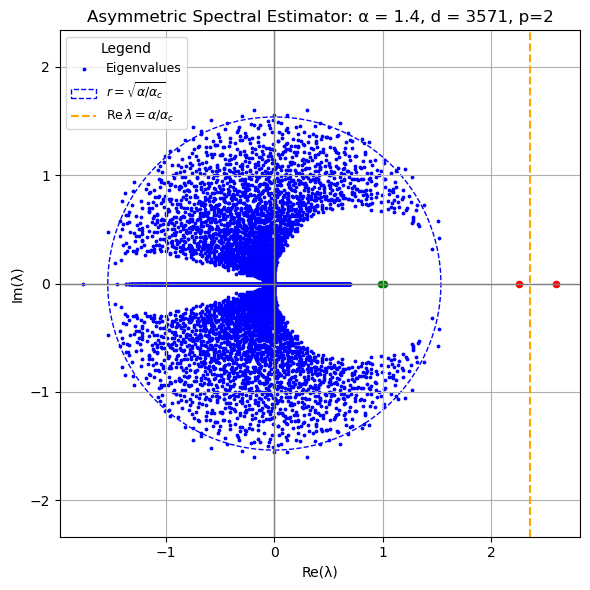

In [ ]:
# Threshold definitions
R = np.sqrt(alpha / alpha_c)        # Radius of the blue spectral circle
thresh_ext = alpha / alpha_c        # Position of the orange vertical threshold line

# Select approximately real eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Red points: top-2 eigenvalues with largest Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# Orange points: eigenvalues within [R, thresh_ext]
orange_vals = []
green_candidates = []
for val in eigvals_real_only:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)

# Green points: top-2 internal real eigenvalues closest to R
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:2]

# Visualization
plt.figure(figsize=(6, 6))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# Spectral radius circle and threshold line
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Mark red points (R1, R2)
for i, val in enumerate(sorted(red_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="red", s=20)

# Mark green points (G1, G2)
for i, val in enumerate(sorted(green_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="green", s=20)
    
# Additional figure settings
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p={p}")

# Legend describing color annotations
plt.legend(loc='upper left', fontsize=9, title="Legend", title_fontsize=10)
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr

# Generalized Overlap evaluation function
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # Orthonormalize W*
    X_cpu = X.cpu().numpy().T  # Shape: (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # Shape: (n, 2)
        U = X_cpu @ V  # Shape: (d, 2)

        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# Eigen-decomposition and variable preparation
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

# Single-point overlap computation
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# Merge results into a DataFrame
all_results = results_red + results_green
df_result = pd.DataFrame(sorted(all_results, key=lambda x: -x[2]),
                         columns=["Label", "Eigenvalue", "Overlap_q"])

print(df_result)


      Label          Eigenvalue  Overlap_q
0  Green1-2  1.011686+0.000000j   0.150286
1  Green1-1  1.011686+0.000000j   0.150286
2  Green2-2  0.980848+0.000000j   0.133787
3  Green2-1  0.980848+0.000000j   0.133787
4    Red1-1  2.255809+0.000000j   0.126955
5    Red1-2  2.255809+0.000000j   0.126955
6    Red2-1  2.599934+0.000000j   0.098329
7    Red2-2  2.599934+0.000000j   0.098329


In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# Map single-point labels (df_result contains ["Label", "Eigenvalue", "Overlap_q"])
pt_label_map = {}
for idx, row in enumerate(df_result.itertuples()):
    pt_id = f"Pt{idx // 2 + 1}-{idx % 2 + 1}"  # e.g., Pt1-1, Pt1-2
    pt_label_map[pt_id] = row.Label

# Compute rank-2 overlaps from pairs of points
def rank2_overlap_from_two_points_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T  # shape: (d, n)

    # Map PtX-Y to corresponding eigenvector components
    v_map = {}
    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        for j in range(2):
            tag = f"{label_prefix}{i+1}-{j+1}"
            v_map[tag] = V[:, j]

    # Evaluate all unique pairs
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # shape: (d, 2)
        U, _ = qr(U, mode='economic')  # Orthonormalize
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # Frobenius norm squared
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False) \
             .reset_index(drop=True)

# Call the function
target_vals = list(red_vals) + list(green_vals)
df_rank2 = rank2_overlap_from_two_points_corrected(
    W_star_np, eigvals_np, eigvecs_np, target_vals, "Pt", X
)

# Replace generic combo labels with actual labels
def replace_combo_label(combo):
    id1, id2 = combo.split(" + ")
    return f"{pt_label_map.get(id1, id1)} + {pt_label_map.get(id2, id2)}"

df_rank2["ComboLabel"] = df_rank2["ComboLabel"].apply(replace_combo_label)

# Show complete results
pd.set_option("display.max_rows", None)
print(df_rank2)


             ComboLabel  Rank2_Overlap_q
0       Red1-2 + Red2-2         0.284033
1       Red1-1 + Red2-2         0.284033
2       Red1-1 + Red2-1         0.284033
3       Red1-2 + Red2-1         0.284033
4       Red2-1 + Red2-2         0.265398
5     Green1-1 + Red2-2         0.260667
6     Green1-2 + Red2-1         0.260667
7     Green1-2 + Red2-2         0.260667
8     Green1-1 + Red2-1         0.260667
9     Green2-1 + Red1-2         0.248556
10    Green2-2 + Red1-2         0.248556
11    Green2-1 + Red1-1         0.248556
12    Green2-2 + Red1-1         0.248556
13  Green1-1 + Green2-2         0.225181
14  Green1-2 + Green2-2         0.225181
15  Green1-1 + Green2-1         0.225181
16  Green1-2 + Green2-1         0.225181
17  Green2-2 + Green2-1         0.220543
18      Red1-1 + Red1-2         0.151842
19    Green1-1 + Red1-2         0.150916
20    Green1-1 + Red1-1         0.150916
21    Green1-2 + Red1-2         0.150916
22    Green1-2 + Red1-1         0.150916
23    Green2-1 +

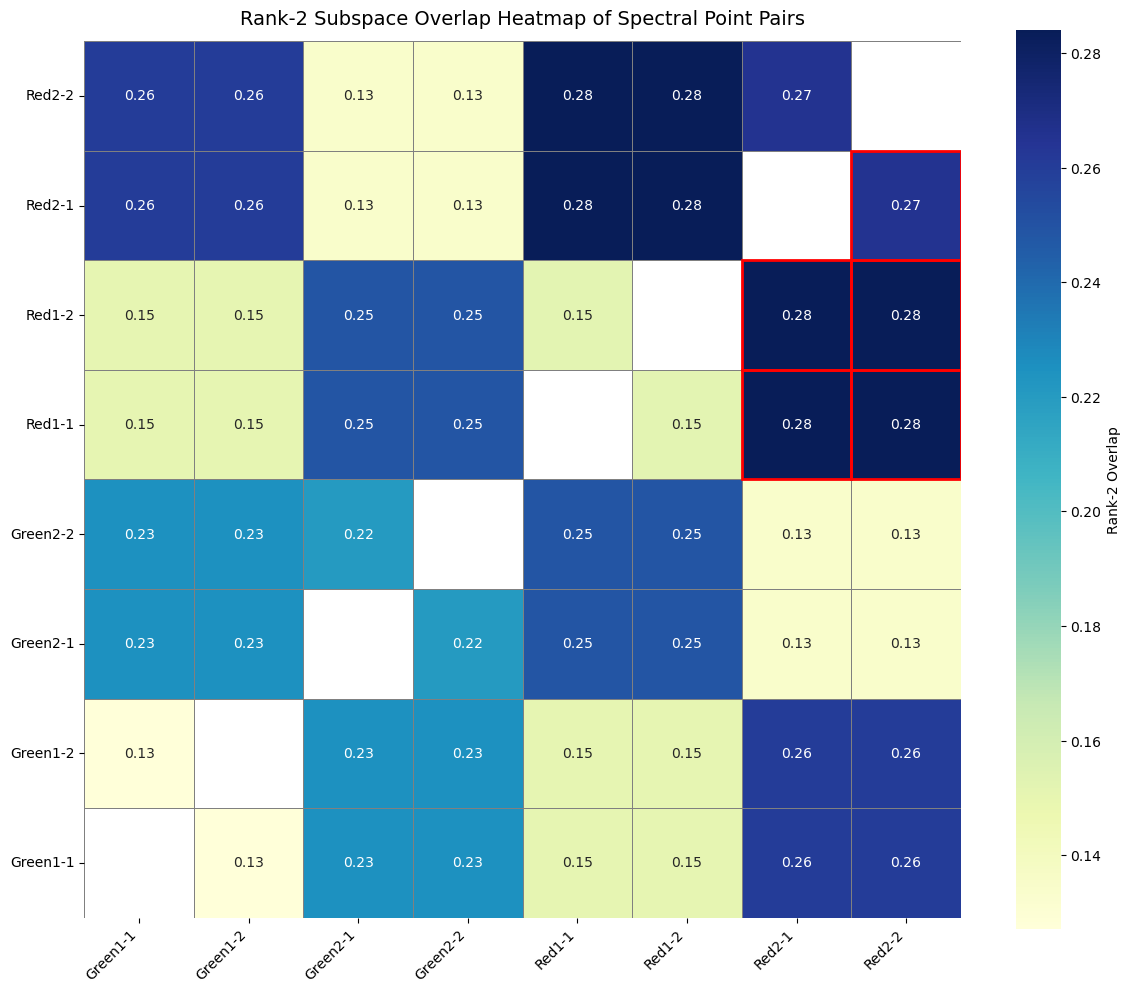

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


# Extract all unique point labels
all_labels = sorted(set(sum([label.split(' + ') for label in df_rank2['ComboLabel']], [])))

# Initialize symmetric matrix
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# Fill upper and lower triangles
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# Set diagonal to NaN (excluded from visualization)
np.fill_diagonal(heatmap_matrix.values, np.nan)

# Select top-5 combinations by overlap
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    heatmap_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    square=True,
    cbar_kws={'label': 'Rank-2 Overlap'},
    linewidths=0.5,
    linecolor='gray'
)

# Title
plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)

# Highlight top-5 pairs with red rectangles
for _, row in top5.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    i = all_labels.index(a)
    j = all_labels.index(b)
    rect = Rectangle((j, i), 1, 1, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

# Axis settings
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()  # Match academic heatmap convention

# Tight layout
plt.tight_layout()
plt.show()
